# üß™ Lab: Modelling & Model Lifecycle ‚Äî Predicting Plant Production (GIST Steel Dataset)

---

## üéØ Learning Outcomes

By completing this lab, you will be able to:

- Prepare and analyse a dataset for modelling.  
- Train and evaluate regression models.  
- Apply cross-validation and hyperparameter tuning using scikit-learn.  
- Track experiments and store models using MLflow and/or Optuna.  
- Reflect on the practical aspects of managing the ML lifecycle.

---



## üß© 1. Data Setup and Exploration
‚è± *Estimated time: 30‚Äì40 min*

### üß≠ Objective  
Understand the dataset structure and the target variable (‚Äúplant-level production‚Äù).

---

### **Task 1.1 ‚Äì Load and Inspect Data**
- Load the GIST Steel dataset. 
- Display basic info (shape, column names, missing values, and data types).  
- Identify the target variable (production) and key features (capacity, ...).


In [1]:
import pandas as pd
plant_data = pd.read_excel('Plant-level-data-Global-Iron-and-Steel-Tracker-September-2025-V1.xlsx',sheet_name='Plant data')
plant_capacities  =  pd.read_excel('Plant-level-data-Global-Iron-and-Steel-Tracker-September-2025-V1.xlsx',sheet_name='Plant capacities and status')
plant_production =   pd.read_excel('Plant-level-data-Global-Iron-and-Steel-Tracker-September-2025-V1.xlsx',sheet_name='Plant production')


In [2]:
## Basic infos plant_data
print("--plant_data--")
print(f"plant_data shape :{plant_data.shape},columns name :{plant_data.columns}")
print("\nCount total NaN in the DataFrame:\n", plant_data.isnull().sum())
print("\nDatatype:\n",plant_data.dtypes)




--plant_data--
plant_data shape :(1209, 44),columns name :Index(['Plant ID', 'Plant name (English)', 'Plant name (other language)',
       'Other plant names (English)', 'Other plant names (other language)',
       'Owner', 'Owner (other language)', 'Owner GEM ID', 'Owner PermID',
       'SOE Status', 'Parent', 'Parent GEM ID', 'Parent PermID',
       'Location address', 'Municipality', 'Subnational unit (province/state)',
       'Country/Area', 'Region', 'Other language location address',
       'Coordinates', 'Coordinate accuracy', 'GEM wiki page',
       'Plant age (years)', 'Announced date', 'Construction date',
       'Start date', 'Pre-retirement announcement date', 'Idled date',
       'Retired date', 'Ferronickel capacity (ttpa)',
       'Sinter plant capacity (ttpa)', 'Coking plant capacity (ttpa)',
       'Pelletizing plant capacity (ttpa)', 'Category steel product',
       'Steel products', 'Steel sector end users', 'Workforce size',
       'ISO 14001', 'ISO 50001', 'Respons

In [3]:
print('---------------------------------------------------------')
print("--plant_capacities--")
print(f"plant_data shape :{plant_capacities.shape},columns name :{plant_capacities.columns}")
print("\nCount total NaN in the DataFrame:\n", plant_capacities.isnull().sum())
print("\nDatatype:\n",plant_capacities.dtypes)


---------------------------------------------------------
--plant_capacities--
plant_data shape :(1744, 15),columns name :Index(['Plant ID', 'Plant name (English)', 'Plant name (other language)',
       'Country/Area', 'Status', 'Start date',
       'Nominal crude steel capacity (ttpa)',
       'Nominal BOF steel capacity (ttpa)',
       'Nominal EAF steel capacity (ttpa)',
       'Nominal OHF steel capacity (ttpa)',
       'Other/unspecified steel capacity (ttpa)',
       'Nominal iron capacity (ttpa)', 'Nominal BF capacity (ttpa)',
       'Nominal DRI capacity (ttpa)',
       'Other/unspecified iron capacity (ttpa)'],
      dtype='object')

Count total NaN in the DataFrame:
 Plant ID                                      0
Plant name (English)                          0
Plant name (other language)                 705
Country/Area                                  0
Status                                        0
Start date                                    0
Nominal crude steel capaci

In [4]:
print('---------------------------------------------------------')
print("--plant_production--")
print(f"plant_data shape :{plant_production.shape},columns name :{plant_production.columns}")
print("\nCount total NaN in the DataFrame:\n", plant_production.isnull().sum())
print("\nDatatype:\n",plant_production.dtypes)

---------------------------------------------------------
--plant_production--
plant_data shape :(1784, 9),columns name :Index([            'Plant ID', 'Plant name (English)',   'Type of production',
                         2019,                   2020,                   2021,
                         2022,                   2023,                   2024],
      dtype='object')

Count total NaN in the DataFrame:
 Plant ID                 0
Plant name (English)     0
Type of production       0
2019                    59
2020                    43
2021                    50
2022                    52
2023                    24
2024                    61
dtype: int64

Datatype:
 Plant ID                object
Plant name (English)    object
Type of production      object
2019                    object
2020                    object
2021                    object
2022                    object
2023                    object
2024                    object
dtype: object


Which columns should we select ? We will choose all the columns where the correlation with years columns of the dataset is the biggest.

In [5]:
## We will merge our three dataframes together on plant ID. We will first focus on the year 2023 
plant_capacities = plant_capacities[plant_capacities['Status']=='operating']
plant_production = plant_production[plant_production['Type of production']=='Crude steel production (ttpa)']
plant_production = plant_production[plant_production[2023]!='unknown']
merge1 = plant_data.merge(plant_capacities,on='Plant ID',how='inner')
merged_df = merge1.merge(plant_production,on='Plant ID',how='inner')

In [6]:
import numpy as np
def unkown_to_nan(df):
    df = df.replace('unknown',np.nan)   
    df = df.replace('>0',np.nan)
    return df  
def search(df,target):
    liste = []
    colonne= df.columns
    for col in colonne : 
        for i in df[col]:
            if i == target : 
                liste.append((col,i))
    return liste

In [7]:
##Relevent features : Region/country, plant age, workforce size, Nominal crude steel capacity,2023,2024
model_df = merged_df[['Plant ID','Region','Plant age (years)','Workforce size','Nominal crude steel capacity (ttpa)',2019,2020,2021,2022,2023,2024]]
model_df = unkown_to_nan(model_df)
print(search(model_df,'>0'))

model_df = model_df.astype({
    'Plant age (years)': 'float64',
    'Workforce size': 'float64',
    'Nominal crude steel capacity (ttpa)': 'float64',
    2023: 'float64',
    2024: 'float64'
})
model_df

[]


C:\Users\cestm\AppData\Local\Temp\ipykernel_16312\2105576074.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('unknown',np.nan)
C:\Users\cestm\AppData\Local\Temp\ipykernel_16312\2105576074.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('>0',np.nan)


Plant ID                   Region  Plant age (years)  \
0    P100000120006  Central & South America              79.00   
1    P100000120009  Central & South America               8.00   
2    P100000120007  Central & South America              65.13   
3    P100000120008  Central & South America              65.00   
4    P100000120032              Middle East              13.00   
..             ...                      ...                ...   
248  P100000120974            North America              40.00   
249  P100000121001                  Eurasia              81.00   
250  P100000121004  Central & South America              63.00   
251  P100000121015             Asia Pacific               8.00   
252  P100000121019             Asia Pacific              18.00   

     Workforce size  Nominal crude steel capacity (ttpa)    2019    2020  \
0            1624.0                               2000.0  1100.0   800.0   
1             787.0                                650.0   167.0   182.0   
2            2993.0                               1720.0   878.0   694.0   
3            3274.0                               3501.0  2162.0  1708.0   
4               NaN                               1265.0     NaN     NaN   
..              ...                                  ...     ...     ...   
248           260.0                                725.0     NaN     NaN   
249         10764.0                               1100.0   950.0   951.0   
250         12676.0                               1020.0     NaN    17.0   
251         13746.0                              11600.0     NaN     NaN   
252          5489.0                               2525.0     NaN     NaN   

       2021    2022    2023  2024  
0    1252.0  1174.0  1100.0   NaN  
1     219.0   372.0   356.0   NaN  
2     873.0   922.0   910.0   NaN  
3    2148.0  2270.0  2226.0   NaN  
4       NaN  1270.0  1265.0   NaN  
..      ...     ...     ...   ...  
248     NaN     NaN   496.0   NaN  
249   976.0     NaN   900.0   NaN  
250   169.0   285.0   120.0   NaN  
251     NaN  5095.0  4632.0   NaN  
252     NaN  2275.0  2068.0   NaN  

[253 rows x 11 columns]

<Axes: >

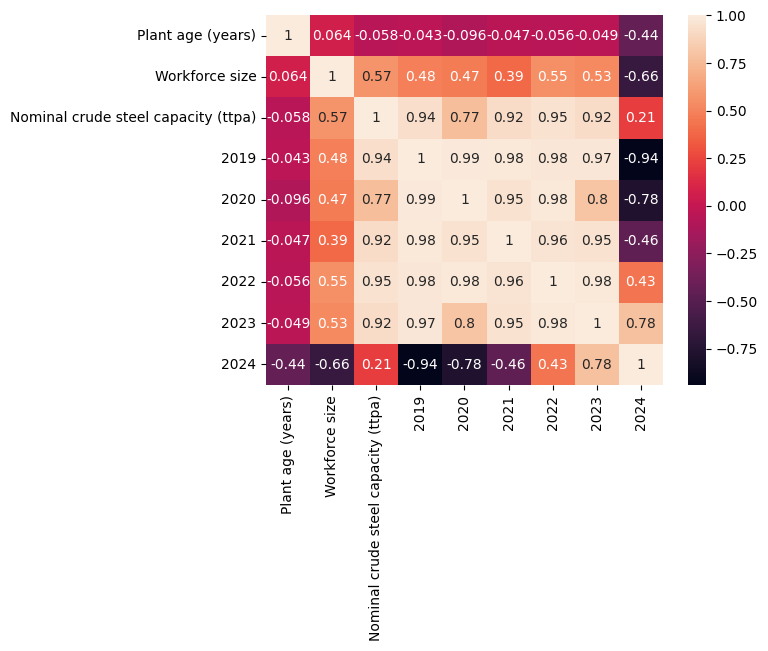

In [8]:
import seaborn as sns
corr = model_df[['Plant age (years)','Workforce size','Nominal crude steel capacity (ttpa)',2019,2020,2021,2022,2023,2024]].corr()
sns.heatmap(corr,annot=True)



> üìù *Markdown prompt:*  
Describe any patterns or potential data quality issues you notice. Which variables might strongly influence production?

---

### **Task 1.2 ‚Äì Data Cleaning**
- Handle missing values appropriately (e.g., imputation, removal).  
- Check for outliers or incorrect entries in numerical columns.  
- Apply transformations if needed (e.g., log-transform for skewed distributions).

> üìù *Markdown prompt:*  
Explain your cleaning choices. Why did you treat the missing or skewed data in that way?

# Since our model_df contains only 253 rows we decided to input the mean for for the missing values. We do that to ensure  
---


In [9]:
# Handling missing values
def fill_with_mean(df):
    colonne = df.columns
    for col in colonne : 
        moyenne =df[col].mean()
        df[col]=df[col].fillna(moyenne)
    return df

print(model_df.isnull().sum(),model_df.shape)
# We are going to focus on the 2023 column at first suince there are few missing values when working with it. 

df_2023 = model_df[['Plant age (years)','Workforce size','Nominal crude steel capacity (ttpa)',2023]]
df_2023 = fill_with_mean(df_2023)
df_2023['Region']=model_df['Region']#adding the Region column back to the dataframe
df_2023['Plant ID']=model_df['Plant ID']#adding the Region column back to the dataframe
print(df_2023.isnull().sum(),df_2023.shape)

Plant ID                                 0
Region                                   0
Plant age (years)                        2
Workforce size                          11
Nominal crude steel capacity (ttpa)      1
2019                                   113
2020                                    92
2021                                    72
2022                                    51
2023                                     2
2024                                   248
dtype: int64 (253, 11)
Plant age (years)                      0
Workforce size                         0
Nominal crude steel capacity (ttpa)    0
2023                                   0
Region                                 0
Plant ID                               0
dtype: int64 (253, 6)


C:\Users\cestm\AppData\Local\Temp\ipykernel_16312\543790628.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]=df[col].fillna(moyenne)
C:\Users\cestm\AppData\Local\Temp\ipykernel_16312\543790628.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['Region']=model_df['Region']#adding the Region column back to the dataframe
C:\Users\cestm\AppData\Local\Temp\ipykernel_16312\543790628.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

# When checking for outliers we will check the z-score that are greater than 3, we are also going to check the distribution of all the variables 

In [10]:
import scipy
def z_score(df): 
    z_score_df = pd.DataFrame()
    colonne = df.columns
    for col in colonne:
        z_score_df['z_score_'+str(col)] = scipy.stats.zscore(df[col])
    return z_score_df
def outliers(df):
    colonne = df.columns
    outlier = pd.DataFrame()
    for col in colonne : 
        petit_df = df[abs(df[col])>3]#variable oin which I stock the df containing the outliers
        outlier['nbr outliers'+col] = [len(petit_df['z_score_2023'])]
    return outlier
z_score_df = z_score(df_2023[['Plant age (years)','Workforce size','Nominal crude steel capacity (ttpa)',2023]])
outlier = outliers(z_score_df)
outlier



nbr outliersz_score_Plant age (years)  nbr outliersz_score_Workforce size  \
0                                      3                                   5   

   nbr outliersz_score_Nominal crude steel capacity (ttpa)  \
0                                                  7         

   nbr outliersz_score_2023  
0                         6

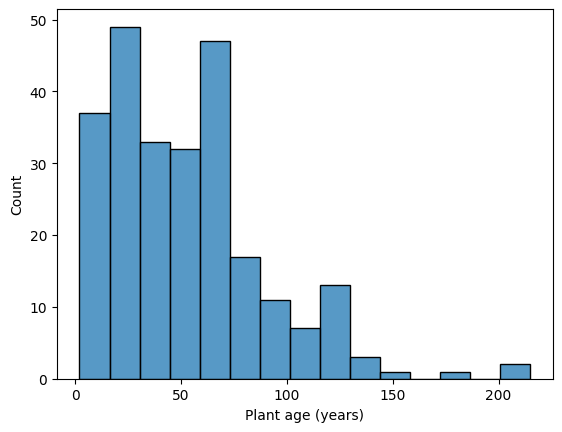

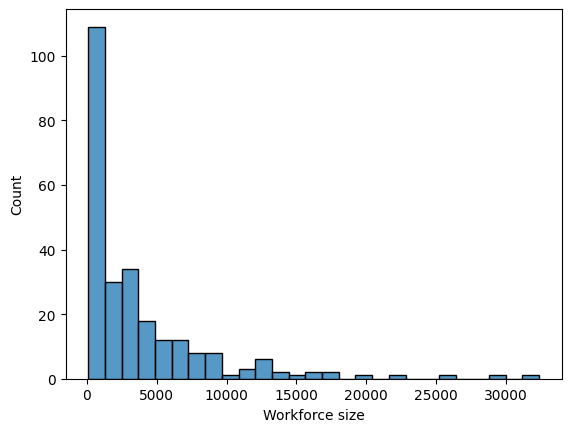

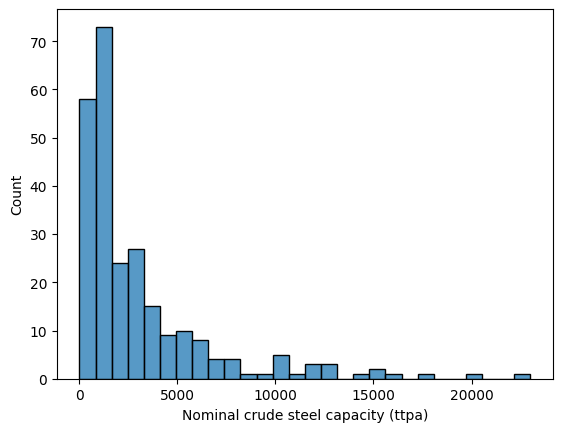

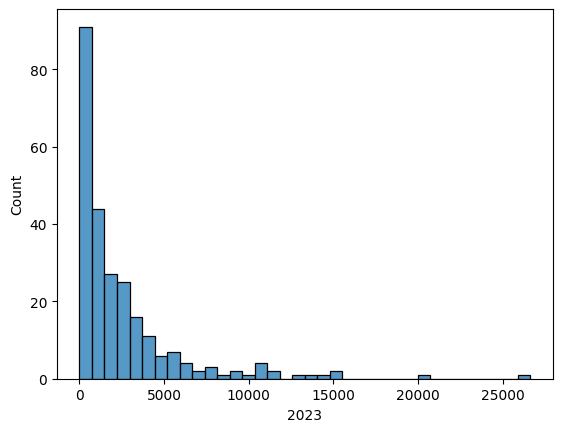

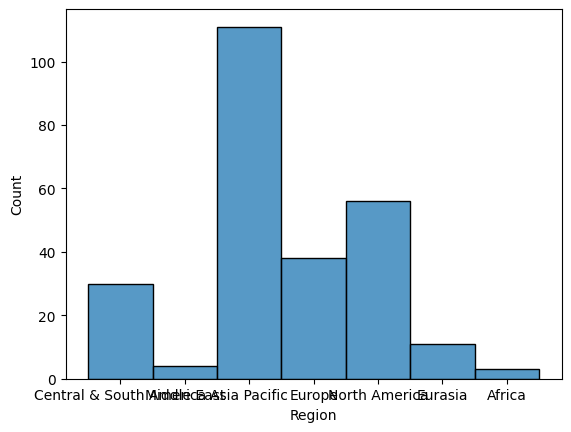

In [11]:
# Check for outliers
import matplotlib.pyplot as plt
def check_distribution(df):
    colonne = df.columns 
    for col in colonne : 
        if col !='Plant ID':
            sns.histplot(df[col])
            plt.show()

check_distribution(df_2023)


Plant age (years) Logscale transformation


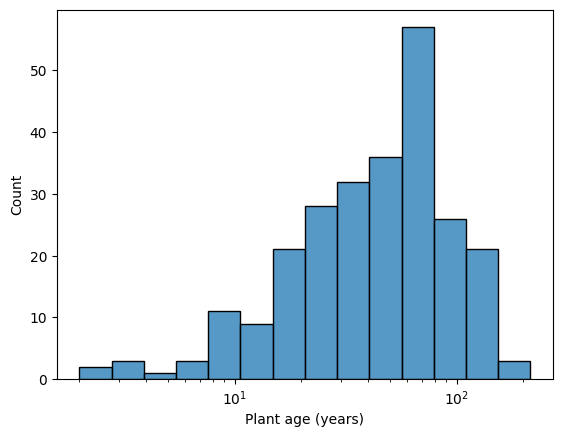

Plant age (years) Box Cox transformation


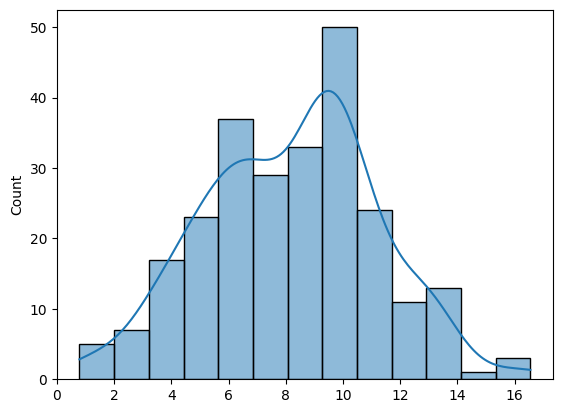

Workforce size Logscale transformation


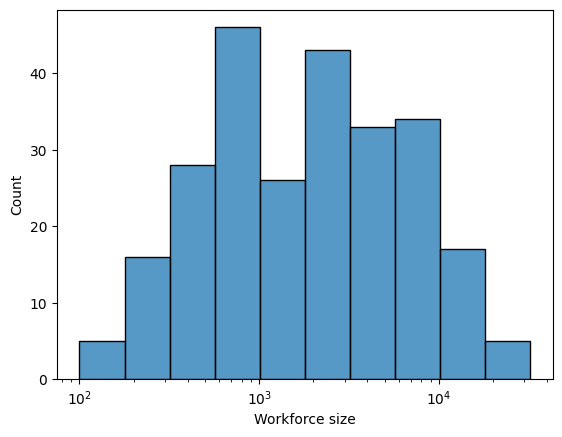

Workforce size Box Cox transformation


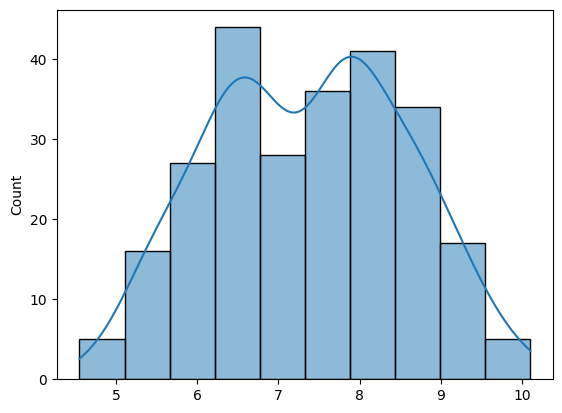

Nominal crude steel capacity (ttpa) Logscale transformation


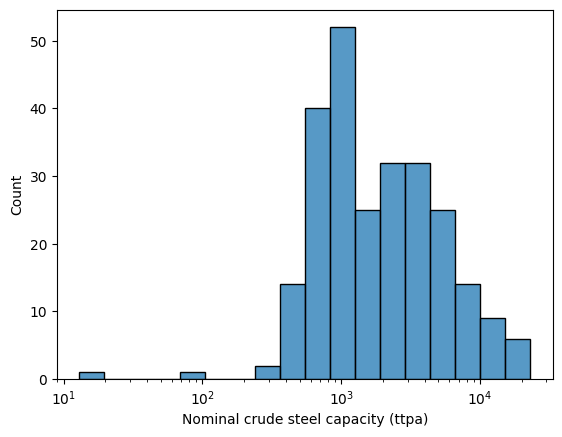

Nominal crude steel capacity (ttpa) Box Cox transformation


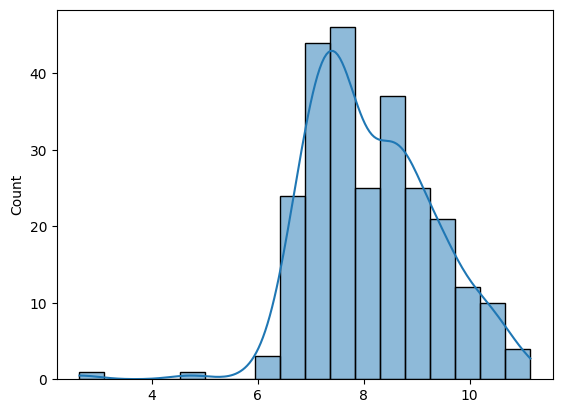

2023 Logscale transformation


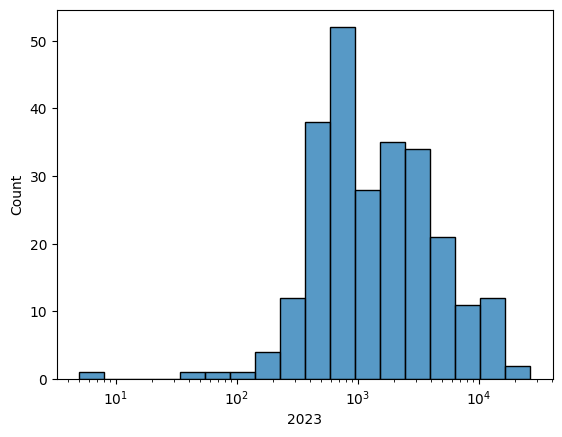

2023 Box Cox transformation


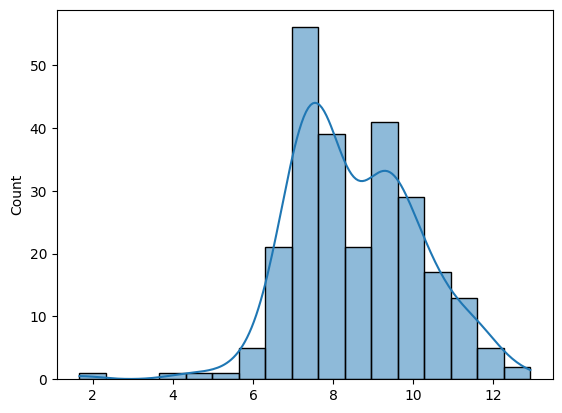

In [12]:
# Display transformation
def display_transformation(df):
    colonne = df.columns
    for col in colonne : 
        if col !='Plant ID'and col!='Region':
            print(str(col)+" Logscale transformation")
            sns.histplot(df[col],log_scale=True)
            plt.show()
            print(str(col)+" Box Cox transformation")
            x_transformed, fitted_lambda = scipy.stats.boxcox(df[col])
            sns.histplot(x_transformed,kde=True)
            plt.show()
    
display_transformation(df_2023)           
            



### **Task 1.3 ‚Äì Feature Engineering**
- Create at least two new variables that might improve model performance (e.g., ‚Äúcapacity per worker‚Äù, ‚Äúenergy efficiency‚Äù).  
- Encode categorical variables and standardize numeric ones.
- Bonus: you are free to use external socioeconomic or environmental data sources to enhance your feature set.

> üìù *Markdown prompt:*  
Document your new feature(s). What business or operational insight do they represent?

---


In [13]:
# Adding two new variables
def capacity_per_worker(df):
    df['capacity_per_worker']=df['Nominal crude steel capacity (ttpa)']/df['Workforce size']
    return df['capacity_per_worker']
def workforce_per_age(df):
    df['workforce_per_age']=df['Workforce size']*df['Plant age (years)']
    return df['workforce_per_age']
df_2023['workforce_times_age']=workforce_per_age(df_2023)
df_2023['capacity_per_worker']=capacity_per_worker(df_2023)
    

C:\Users\cestm\AppData\Local\Temp\ipykernel_16312\1711484827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['workforce_per_age']=df['Workforce size']*df['Plant age (years)']
C:\Users\cestm\AppData\Local\Temp\ipykernel_16312\1711484827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['workforce_times_age']=workforce_per_age(df_2023)
C:\Users\cestm\AppData\Local\Temp\ipykernel_16312\1711484827.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [14]:
# Encode categorical variable and normalize numerical
def encode_region(df):
    rez = []
    for el in df['Region']:
        if el == 'Central & South America':
            rez.append(1)
        elif el =='Middle East':
            rez.append(2)
        elif el =='Asia Pacific':
            rez.append(3)
        elif el =='Europe':
            rez.append(4)
        elif el =='North America':
            rez.append(5)
        elif el =='Eurasia':
            rez.append(5)
        elif el == 'Africa':
            rez.append(6)
    return rez
# Add encoded Region to standardised df 

z_score_df['Region encoded']=encode_region(df_2023)   
z_score_df['Plant ID']= df_2023['Plant ID']  
z_score_df['Production'] = df_2023[2023]
z_score_df['z_score_workforce_times_age']=scipy.stats.zscore(df_2023['workforce_times_age'])
z_score_df['z_score_capacity_per_worker']=scipy.stats.zscore(df_2023['capacity_per_worker'])        
        
        

In [15]:
z_score_df

z_score_Plant age (years)  z_score_Workforce size  \
0                     0.703163           -4.321583e-01   
1                    -1.223393           -6.044185e-01   
2                     0.326807           -1.504090e-01   
3                     0.323279           -9.257729e-02   
4                    -1.087720           -9.359005e-17   
..                         ...                     ...   
248                  -0.355086           -7.128786e-01   
249                   0.757433            1.448915e+00   
250                   0.269010            1.842417e+00   
251                  -1.223393            2.062630e+00   
252                  -0.952047            3.632845e-01   

     z_score_Nominal crude steel capacity (ttpa)  z_score_2023  \
0                                      -0.295277     -0.424631   
1                                      -0.667647     -0.639790   
2                                      -0.372509     -0.479577   
3                                       0.118742     -0.099000   
4                                      -0.498012     -0.376914   
..                                           ...           ...   
248                                    -0.646959     -0.599303   
249                                    -0.543524     -0.482469   
250                                    -0.565590     -0.708039   
251                                     2.352682      0.596796   
252                                    -0.150467     -0.144693   

     Region encoded       Plant ID  Production  z_score_workforce_times_age  \
0                 1  P100000120006      1100.0                    -0.214875   
1                 1  P100000120009       356.0                    -0.540052   
2                 1  P100000120007       910.0                    -0.037259   
3                 1  P100000120008      2226.0                     0.010387   
4                 2  P100000120032      1265.0                    -0.427803   
..              ...            ...         ...                          ...   
248               5  P100000120974       496.0                    -0.529113   
249               5  P100000121001       900.0                     1.767073   
250               1  P100000121004       120.0                     1.571711   
251               3  P100000121015      4632.0                    -0.263726   
252               3  P100000121019      2068.0                    -0.293488   

     z_score_capacity_per_worker  
0                      -0.243060  
1                      -0.457730  
2                      -0.590704  
3                      -0.328902  
4                      -0.715064  
..                           ...  
248                     0.580961  
249                    -0.840769  
250                    -0.852268  
251                    -0.448224  
252                    -0.651391  

[253 rows x 9 columns]


## üîç 1.4 Feature Relationships and Correlations
‚è± *Estimated time: 20‚Äì25 min*

### üß≠ Objective  
Before training models, it‚Äôs essential to understand how features relate to each other and to the target variable ‚Äî both linearly and nonlinearly. This helps identify redundant or uninformative predictors and guides model choice.

---

### **Task 1.4.1 ‚Äì Correlation Matrix (Linear Relationships)**
- Compute a **correlation matrix** (e.g., using `df.corr()`, `seaborn.heatmap`, `skrub`) to examine pairwise linear relationships among numerical features.  
- Focus on correlations between each feature and the target (`production`), as well as between features themselves.

> üìù *Markdown prompt:*  
Which variables show the strongest correlation with production?  
Do any features appear redundant or highly correlated with each other?

---


<Axes: >

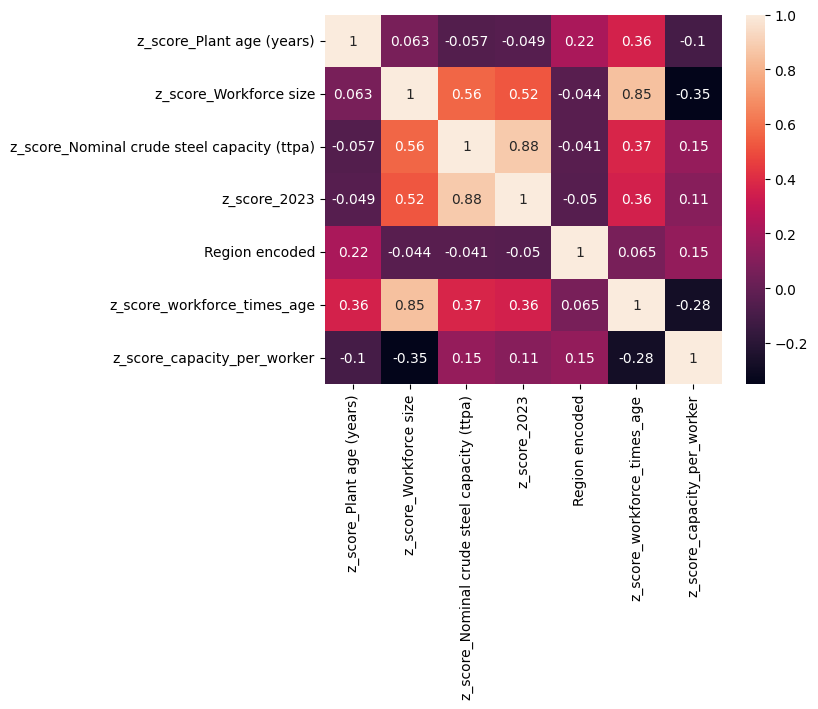

In [16]:
correlation = z_score_df[['z_score_Plant age (years)','z_score_Workforce size','z_score_Nominal crude steel capacity (ttpa)','z_score_2023','Region encoded','z_score_workforce_times_age','z_score_capacity_per_worker']].corr()
sns.heatmap(correlation,annot=True)

## üßÆ 2. Building Baseline & Linear Models
‚è± *Estimated time: 25‚Äì30 min*

### üß≠ Objective  
Establish a simple baseline, then train and interpret a linear model.

---

### **Task 2.1 ‚Äì Baseline**
- Compute a simple baseline predictor (e.g., mean or median production).  
- Measure RMSE or MAE compared to actual values.

> üìù *Markdown prompt:*  
Why is it useful to have a baseline model before trying more complex ones?

---


In [17]:
# Computing baseline here we choose the mean and computing RMSE and MAE
import sklearn.metrics
def baseline(df,target):
    y_true = df[target]
    y_pred = np.full_like(y_true, fill_value=y_true.mean(), dtype=np.float64)
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)

    print(f"RMSE baseline :{rmse}")
    print(f"MAE baseline :{mae}")

baseline(z_score_df,'Production')


    


RMSE baseline :3457.908858753857
MAE baseline :2222.4261216005543



### **Task 2.2 ‚Äì Linear Regression**
- Train a multiple linear regression model using the key plant variables.  
- Display coefficients and interpret their meaning.  
- Evaluate the model on training and test data.

> üìù *Markdown prompt:*  
Interpret one positive and one negative coefficient. What do they tell you about plant performance drivers?

---


In [18]:
z_score_df.columns

Index(['z_score_Plant age (years)', 'z_score_Workforce size',
       'z_score_Nominal crude steel capacity (ttpa)', 'z_score_2023',
       'Region encoded', 'Plant ID', 'Production',
       'z_score_workforce_times_age', 'z_score_capacity_per_worker'],
      dtype='object')

In [19]:
# Split the data into traning and testing set
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def prepare_data(df,target,test_size=0.2,random_state=42):
    features =['z_score_Plant age (years)', 'z_score_Workforce size',
       'z_score_Nominal crude steel capacity (ttpa)',
       'Region encoded','z_score_workforce_times_age', 'z_score_capacity_per_worker']

    
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data(z_score_df, target='Production', test_size=0.2, random_state=42)

In [20]:
def train_linear_model(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model
modele = train_linear_model(X_train, y_train)


In [21]:
def display_coefficients(model, X):
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })
    
    print("Intercept:", model.intercept_)
    print("\nModel Coefficients:")
    print(coef_df)
    
    print("\nInterpretation:")
    print("- A positive coefficient ‚Üí the variable increases the target (Production).")
    print("- A negative coefficient ‚Üí the variable decreases the target, holding all other variables constant.")
    
    return coef_df

coef_df = display_coefficients(modele, X_train)


Intercept: 2777.17256283294

Model Coefficients:
                                       Feature  Coefficient
0                    z_score_Plant age (years)     9.042628
1                       z_score_Workforce size   231.623393
2  z_score_Nominal crude steel capacity (ttpa)  3007.548183
3                               Region encoded   -51.622205
4                  z_score_workforce_times_age   -93.694401
5                  z_score_capacity_per_worker   -54.659158

Interpretation:
- A positive coefficient ‚Üí the variable increases the target (Production).
- A negative coefficient ‚Üí the variable decreases the target, holding all other variables constant.


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n Test Set Evaluation:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R¬≤  : {r2:.3f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}
rezz =evaluate_model(modele, X_test, y_test)


 Test Set Evaluation:
RMSE: 1088.36
MAE : 593.08
R¬≤  : 0.718


## üîÅ 3. Model Evaluation and Selection
‚è± *Estimated time: 45‚Äì60 min*

### üß≠ Objective  
Use cross-validation to estimate generalization performance and compare multiple model types.

---

### **Task 3.1 ‚Äì Cross-Validation**
- Apply **K-Fold cross-validation** (e.g., K=5).  
- Record the average RMSE, MAE, and R¬≤ across folds.

> üìù *Markdown prompt:*  
Summarize your results. How stable is performance across folds? What might this indicate about model variance?

---


In [23]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
def cross_validation_metrics(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)


    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
                              greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


    rmse_scores = -cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
    r2_scores  =  cross_val_score(model, X, y, cv=kf, scoring='r2')

    print(" Cross-Validation Results")
    print(f"Average RMSE: {rmse_scores.mean():.2f} ¬± {rmse_scores.std():.2f}")
    print(f"Average MAE : {mae_scores.mean():.2f} ¬± {mae_scores.std():.2f}")
    print(f"Average R¬≤  : {r2_scores.mean():.3f} ¬± {r2_scores.std():.3f}")

    return {
        'RMSE_mean': rmse_scores.mean(), 'RMSE_std': rmse_scores.std(),
        'MAE_mean': mae_scores.mean(),   'MAE_std': mae_scores.std(),
        'R2_mean': r2_scores.mean(),     'R2_std': r2_scores.std()
    }

features =['z_score_Plant age (years)', 'z_score_Workforce size',
       'z_score_Nominal crude steel capacity (ttpa)',
       'Region encoded','z_score_workforce_times_age', 'z_score_capacity_per_worker']

    
X = z_score_df[features]
y = z_score_df['Production']
cross_validation_metrics(modele, X, y, k=5)


 Cross-Validation Results
Average RMSE: 1495.55 ¬± 731.79
Average MAE : 744.71 ¬± 220.80
Average R¬≤  : 0.777 ¬± 0.128


{'RMSE_mean': 1495.5476267325685,
 'RMSE_std': 731.7949225790906,
 'MAE_mean': 744.7108361875904,
 'MAE_std': 220.80440583099315,
 'R2_mean': 0.7768346866245766,
 'R2_std': 0.12812008112204018}

### **Task 3.2 ‚Äì Model Comparison**
Train and compare at least **three models**:
- Linear Regression  
- Ridge Regression (regularized linear)  
- Random Forest Regressor  

Record cross-validation performance for each model.

> üìù *Markdown prompt:*  
Create a small results table. Which model performs best? Why might that be the case given the dataset‚Äôs characteristics?

---

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
def try_rf(X_train, y_train,X_test,y_test):
    
    rf_model.fit(X_train, y_train)
    val_pred = rf_model.predict(X_test)
    
    print(" R¬≤:", r2_score(y_test, val_pred))

    print(" RMSE:", np.sqrt(mean_squared_error(y_test, val_pred)))

    print("MAE:", mean_absolute_error(y_test, val_pred))
    return rf_model
try_rf(X_train, y_train,X_test,y_test)
cross_validation_metrics(rf_model, X, y, k=5)


 R¬≤: 0.6468121558116848
 RMSE: 1218.8736828893739
MAE: 787.8967176426356
 Cross-Validation Results
Average RMSE: 1705.37 ¬± 678.60
Average MAE : 878.41 ¬± 248.76
Average R¬≤  : 0.729 ¬± 0.114


{'RMSE_mean': 1705.372766254603,
 'RMSE_std': 678.5966256461786,
 'MAE_mean': 878.4145904303172,
 'MAE_std': 248.7631901555961,
 'R2_mean': 0.7292812469627057,
 'R2_std': 0.11410801922795522}

In [25]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(
    alpha=10,          
    random_state=42
)


def try_ridge(X_train, y_train, X_test, y_test):
    ridge_model.fit(X_train, y_train)
    val_pred = ridge_model.predict(X_test)
    
    print(" Ridge Regression Performance:")
    print(f"R¬≤   : {r2_score(y_test, val_pred):.3f}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_test, val_pred)):.2f}")
    print(f"MAE  : {mean_absolute_error(y_test, val_pred):.2f}")
    
    return ridge_model

try_ridge(X_train, y_train, X_test, y_test)


cross_validation_metrics(ridge_model, X, y, k=5)

 Ridge Regression Performance:
R¬≤   : 0.724
RMSE : 1077.18
MAE  : 628.34
 Cross-Validation Results
Average RMSE: 1512.38 ¬± 717.00
Average MAE : 779.37 ¬± 222.78
Average R¬≤  : 0.776 ¬± 0.123


{'RMSE_mean': 1512.384441565641,
 'RMSE_std': 717.0022898415291,
 'MAE_mean': 779.3705254224902,
 'MAE_std': 222.77859858945197,
 'R2_mean': 0.7759830523465366,
 'R2_std': 0.12273571270018409}

### **Task 3.3 ‚Äì Hyperparameter Optimization**
- Use **RandomizedSearchCV** or **GridSearchCV** to tune the top model (e.g., Random Forest).  
- Report the best parameters and corresponding validation score.

> üìù *Markdown prompt:*  
Discuss the role of hyperparameter tuning. How did tuning change your model‚Äôs performance compared to default settings?

---


In [29]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

ridge = Ridge(random_state=42)

param_distributions = {
    'alpha': np.logspace(-3, 3, 100),
    'solver': ['auto', 'saga', 'lbfgs', 'cholesky']
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=ridge,
    param_distributions=param_distributions,
    n_iter=20,               
    cv=cv,
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
best_ridge = search.best_estimator_
best_params = search.best_params_
best_score = search.best_score_

print(" Best Parameters:")
print(best_params)
print(f"Best Cross-Validation R¬≤: {best_score:.3f}")

y_pred = best_ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n Test Set Performance (Best Ridge Model):")
print(f"R¬≤   : {r2:.3f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
 Best Parameters:
{'solver': 'auto', 'alpha': 17.47528400007683}
Best Cross-Validation R¬≤: 0.747

 Test Set Performance (Best Ridge Model):
R¬≤   : 0.725
RMSE : 1075.09
MAE  : 653.72


c:\Users\cestm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\cestm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\cestm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\cestm\AppDa

## It is very close from the original parameters choosen but there is still an improvement.

## ‚öôÔ∏è 4. Model Lifecycle: Tracking, Saving, and Loading
‚è± *Estimated time: 30‚Äì40 min*

### üß≠ Objective  
Apply tools that support reproducible ML experiments.

---

### **Task 4.1 ‚Äì Experiment Tracking with MLflow**
- Use MLflow to log parameters (model type, hyperparameters), metrics (RMSE, R¬≤), and artifacts (plots or model files).  
- Run and record at least two model experiments.

> üìù *Markdown prompt:*  
Describe how MLflow helps manage your experiments. What advantages does it give compared to manual tracking?

---

In [30]:
import mlflow
import mlflow.sklearn
mlflow.set_experiment("Steel_Production_Prediction")
def run_experiment(model, model_name, X_train, y_train, X_test, y_test):
    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        r2 = r2_score(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)

        mlflow.log_param("model_type", model_name)
        if hasattr(model, "get_params"):
            mlflow.log_params(model.get_params())
        mlflow.log_metric("R2", r2)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)

        mlflow.sklearn.log_model(model, model_name)

        print(f" {model_name} logged to MLflow")
        print(f"R¬≤: {r2:.3f} | RMSE: {rmse:.2f} | MAE: {mae:.2f}")

        return {"Model": model_name, "R2": r2, "RMSE": rmse, "MAE": mae}
    
ridge = Ridge(alpha=10, random_state=42)
rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=25,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

exp1 = run_experiment(ridge, "Ridge_Regression", X_train, y_train, X_test, y_test)
exp2 = run_experiment(rf, "Random_Forest", X_train, y_train, X_test, y_test)


2025/10/26 21:24:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/26 21:24:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Ridge_Regression logged to MLflow
R¬≤: 0.724 | RMSE: 1077.18 | MAE: 628.34


2025/10/26 21:24:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/26 21:24:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


 Random_Forest logged to MLflow
R¬≤: 0.669 | RMSE: 1180.21 | MAE: 749.34


### **Task 4.2 ‚Äì Hyperparameter Optimization with Optuna**
- Define an Optuna study to optimize one model (e.g., Ridge or Random Forest).  
- Record the number of trials and best result.

> üìù *Markdown prompt:*  
Explain what Optuna is doing behind the scenes. How is it different from Grid or Random Search?

---

In [31]:
import optuna

def objective(trial):
    
    alpha = trial.suggest_float('alpha', 0.001, 100.0, log=True) 
    model = Ridge(alpha=alpha, random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    return -scores.mean()

study = optuna.create_study(direction='minimize', study_name="Ridge_Optimization")
study.optimize(objective, n_trials=50)
print(" Best alpha found :", study.best_params['alpha'])
print("Best R¬≤ avg (CV) :", -study.best_value)


[I 2025-10-26 21:29:00,379] A new study created in memory with name: Ridge_Optimization
[I 2025-10-26 21:29:00,459] Trial 0 finished with value: -0.7768787926216344 and parameters: {'alpha': 0.15268923376077467}. Best is trial 0 with value: -0.7768787926216344.
[I 2025-10-26 21:29:00,484] Trial 1 finished with value: -0.7770103417160333 and parameters: {'alpha': 0.6782987314200777}. Best is trial 1 with value: -0.7770103417160333.
[I 2025-10-26 21:29:00,512] Trial 2 finished with value: -0.7768663048989963 and parameters: {'alpha': 0.10847804764443517}. Best is trial 1 with value: -0.7770103417160333.
[I 2025-10-26 21:29:00,538] Trial 3 finished with value: -0.7102755421847377 and parameters: {'alpha': 86.96113135609549}. Best is trial 1 with value: -0.7770103417160333.
[I 2025-10-26 21:29:00,565] Trial 4 finished with value: -0.776867165904973 and parameters: {'alpha': 0.11150050216276354}. Best is trial 1 with value: -0.7770103417160333.
[I 2025-10-26 21:29:00,592] Trial 5 finished w

 Best alpha found : 3.184997729095297
Best R¬≤ avg (CV) : 0.7772770842332277


### **Task 4.3 ‚Äì Model Storage**
- Save the best performing model to a file (e.g., using joblib or MLflow‚Äôs model registry).  
- Demonstrate loading the saved model and re-evaluating it on the test set.

> üìù *Markdown prompt:*  
Why is it important to store both model parameters and metadata? How would you ensure version control of models in a production setting?

---

## Optuna updates the model hyperparameters based on past trials instead of testing them all like RandomizedSearchCV.
## It bases its approach on using a Bayesian approach called the Tree-structured Parzen Estimator (TPE)

In [ ]:
import joblib
best_alpha = study.best_params['alpha']
best_ridge = Ridge(alpha=best_alpha, random_state=42)
best_ridge.fit(X_train, y_train)
y_pred = best_ridge.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(" Best Ridge Model (before saving):")
print(f"Alpha: {best_alpha:.3f}")
print(f"R¬≤   : {r2:.3f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
joblib.dump(best_ridge, "ridge_best_model.pkl")
print("\n Model saved as ridge_best_model.pkl")
loaded_model = joblib.load("ridge_best_model.pkl")
print(" Model loaded successfully.")
y_loaded_pred = loaded_model.predict(X_test)
r2_loaded = r2_score(y_test, y_loaded_pred)
rmse_loaded = np.sqrt(mean_squared_error(y_test, y_loaded_pred))
mae_loaded = mean_absolute_error(y_test, y_loaded_pred)

print("\n Ridge Model (after loading):")
print(f"R¬≤   : {r2_loaded:.3f}")
print(f"RMSE : {rmse_loaded:.2f}")
print(f"MAE  : {mae_loaded:.2f}")


 Best Ridge Model (before saving):
Alpha: 3.185
R¬≤   : 0.721
RMSE : 1083.84
MAE  : 603.14

 Model saved as ridge_best_model.pkl
üìÇ Model loaded successfully.

 Ridge Model (after loading):
R¬≤   : 0.721
RMSE : 1083.84
MAE  : 603.14



## üöÄ 5. Deployment & Monitoring (Conceptual)
‚è± *Estimated time: 15‚Äì20 min*

### üß≠ Objective  
Reflect on how models transition from training to production and stay reliable over time.

---

### **Task 5.1 ‚Äì Deployment Planning**
> üìù *Markdown prompt:*  
Describe how you would deploy your model in a business environment (e.g., via REST API, batch pipeline).  
Which metrics would you monitor in production?

---

### **Task 5.2 ‚Äì Detecting Model Drift**
> üìù *Markdown prompt:*  
What signs might indicate your model needs retraining?  
Give one example of **data drift** and one of **concept drift** relevant to steel plant production.

---

## üí¨ 6. Reflection
‚è± *Estimated time: 10‚Äì15 min*

> üìù *Markdown prompt:*  
1. Which step of the modelling lifecycle did you find most challenging and why?  
2. What would you do differently if you had access to additional plant-level data?  
3. How would you communicate model insights to a business audience?

---

‚úÖ **End of Lab**

Next week: Short quiz on theoretical concepts (distributions, regression, model selection, and experiment tracking).

